# ARR by Product Line Analysis Plan

## Major Assumptions
We have access to a Lucid Software database containing a seat_licenses table with product information and licensing data. ARR (Annual Recurring Revenue) can be calculated from this table, likely using seat counts, pricing, or revenue fields. Product lines are identifiable through a product column or similar field in the seat_licenses table.

## Plan
- [x] Connect to database and explore seat_licenses table structure
  - [x] Identify product values, pricing/revenue fields, and date columns
  - [x] Understand data granularity and any filtering needed (active licenses, date ranges)
- [x] Calculate ARR by product line
  - [x] Determine ARR calculation methodology based on available fields
  - [x] Aggregate revenue metrics by product
- [x] Visualize and summarize ARR distribution across product lines
  - [x] Create comparison visualization of ARR by product
  - [x] Document key findings and product line contributions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sqlalchemy import create_engine

# SignalPilot dark theme
plt.rcParams.update({
    'figure.figsize': (10, 6), 'figure.dpi': 100, 'savefig.dpi': 300,
    'font.size': 11, 'axes.titlesize': 14, 'axes.labelsize': 12,
    'xtick.labelsize': 10, 'ytick.labelsize': 10, 'legend.fontsize': 10,
    'axes.spines.top': False, 'axes.spines.right': False,
    'figure.facecolor': '#08070e', 'axes.facecolor': '#12101e',
    'axes.edgecolor': '#272336', 'axes.labelcolor': '#e9eaeb',
    'text.color': '#FAFAFA', 'xtick.color': '#a4a7ae', 'ytick.color': '#a4a7ae',
    'grid.color': '#1d182b', 'legend.facecolor': '#12101e',
    'legend.edgecolor': '#272336', 'legend.labelcolor': '#e9eaeb',
    'savefig.facecolor': '#08070e',
})
COLORS = {'primary': '#c4b5fd', 'secondary': '#ff8dc4', 'tertiary': '#8b5cf6',
          'blue': '#73acfb', 'green': '#4ca86f', 'yellow': '#fec163'}
CATEGORICAL_PALETTE = ['#c4b5fd', '#ff8dc4', '#8b5cf6', '#73acfb', '#fec163', '#4ca86f']

# Connect to Lucid Software database
engine = create_engine(os.environ['LUCID_SOFTWARE_CONNECTION_URL'])

# Load seat licenses with active filter (end_date is null = currently active)
query = """
SELECT sl.*, a.company_name, a.segment, a.industry
FROM seat_licenses sl
LEFT JOIN accounts a ON sl.account_id = a.account_id
WHERE sl.end_date IS NULL  -- Currently active licenses
"""
df = pd.read_sql(query, engine)
print(f"Active licenses: {len(df):,}")
df.head()

Active licenses: 2,467


,license_id,account_id,product,seats_purchased,mrr_usd,start_date,end_date,renewal_date,license_type,auto_renew,provisioned_by,company_name,segment,industry
0,50475,10409,lucidchart,8,9131.82,2025-08-07,None,2026-08-07,premium,True,sales,Company 10409,mid_market,healthcare
1,52118,11731,lucidchart,9,6364.86,2025-09-07,None,2026-09-07,premium,True,self_serve,Company 11731,mid_market,government
2,52259,11838,lucidchart,42,2991.06,2024-02-15,None,2026-02-14,standard,True,sales,Company 11838,enterprise,manufacturing
3,50948,10785,lucidchart,23,6880.72,2024-07-25,None,2026-07-25,standard,False,self_serve,Company 10785,enterprise,pharma
4,50081,10082,lucidchart,7,3756.17,2024-12-17,None,2026-12-17,standard,True,self_serve,Company 10082,smb,real_estate


In [2]:
# Calculate ARR by product line (MRR × 12)
arr_by_product = df.groupby('product').agg(
    mrr_total=('mrr_usd', 'sum'),
    license_count=('license_id', 'count'),
    total_seats=('seats_purchased', 'sum')
).reset_index()
arr_by_product['arr_usd'] = arr_by_product['mrr_total'] * 12
arr_by_product['arr_millions'] = arr_by_product['arr_usd'] / 1_000_000
arr_by_product = arr_by_product.sort_values('arr_usd', ascending=False)

# Calculate percentages
total_arr = arr_by_product['arr_usd'].sum()
arr_by_product['pct_of_total'] = arr_by_product['arr_usd'] / total_arr * 100

# Format product names for display
arr_by_product['product_display'] = arr_by_product['product'].str.replace('lucid', 'Lucid').str.title()
arr_by_product

,product,mrr_total,license_count,total_seats,arr_usd,arr_millions,pct_of_total,product_display
0,lucidchart,6833911.22,1204,22315,82006934.64,82.006935,56.555825,Lucidchart
2,lucidspark,3416730.46,705,14501,41000765.52,41.000766,28.276049,Lucidspark
1,lucidscale,1832837.34,558,10916,21994048.08,21.994048,15.168126,Lucidscale


In [3]:
# Cross-sell analysis: How many products does each account have?
cross_sell = df.groupby('account_id').agg(
    products=('product', lambda x: list(set(x))),
    product_count=('product', 'nunique'),
    total_arr=('mrr_usd', lambda x: x.sum() * 12),
    total_seats=('seats_purchased', 'sum')
).reset_index()

# Categorize accounts by product mix
cross_sell['cross_sell_status'] = cross_sell['product_count'].map({
    1: 'Single Product', 2: '2 Products', 3: 'Full Suite (3 Products)'
})

# Summary stats
cross_sell_summary = cross_sell.groupby('cross_sell_status').agg(
    account_count=('account_id', 'count'),
    total_arr=('total_arr', 'sum'),
    avg_arr=('total_arr', 'mean'),
    avg_seats=('total_seats', 'mean')
).reset_index()
cross_sell_summary['arr_millions'] = cross_sell_summary['total_arr'] / 1_000_000
cross_sell_summary['pct_accounts'] = cross_sell_summary['account_count'] / cross_sell_summary['account_count'].sum() * 100
cross_sell_summary = cross_sell_summary.sort_values('account_count', ascending=False)
cross_sell_summary

,cross_sell_status,account_count,total_arr,avg_arr,avg_seats,arr_millions,pct_accounts
2,Single Product,1072,65731187.04,61316.405821,19.805970,65.731187,64.656212
0,2 Products,363,42126944.04,116052.187438,32.099174,42.126944,21.893848
1,Full Suite (3 Products),223,37143617.16,166563.305650,66.582960,37.143617,13.449940


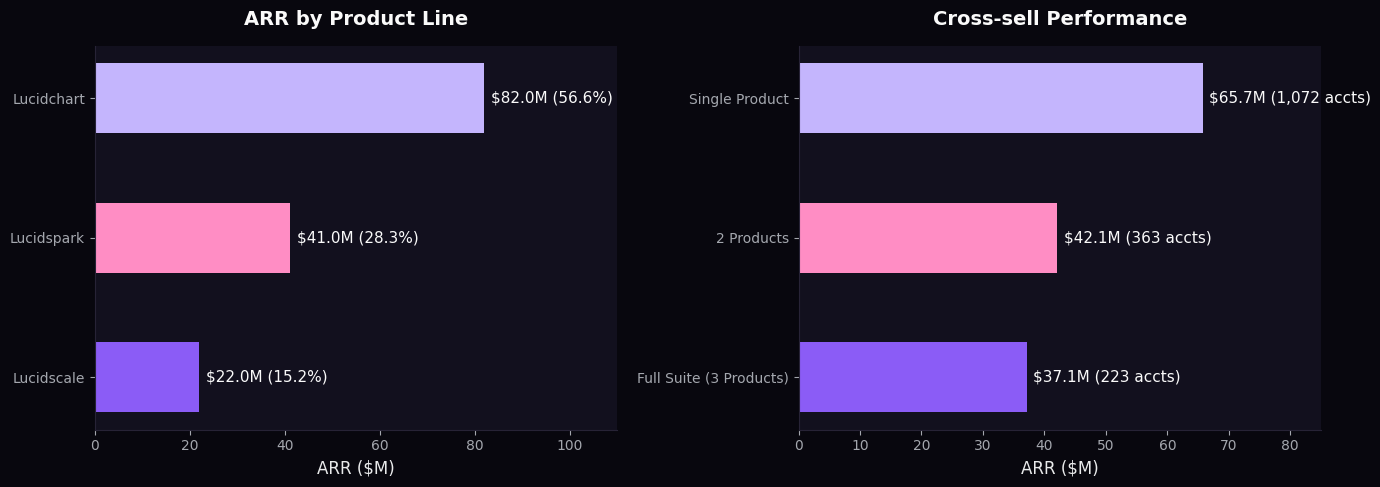

In [5]:
# Create visualization: ARR by Product Line & Cross-sell Performance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Chart 1: ARR by Product Line
ax1 = axes[0]
bars1 = ax1.barh(arr_by_product['product_display'], arr_by_product['arr_millions'], 
                 color=CATEGORICAL_PALETTE[:3], height=0.5)
ax1.set_xlabel('ARR ($M)')
ax1.set_title('ARR by Product Line', fontweight='bold', pad=15)
for bar, val, pct in zip(bars1, arr_by_product['arr_millions'], arr_by_product['pct_of_total']):
    ax1.text(val + 1.5, bar.get_y() + bar.get_height()/2, 
             f'${val:.1f}M ({pct:.1f}%)', va='center', fontsize=11, color='#FAFAFA')
ax1.set_xlim(0, 110)
ax1.invert_yaxis()

# Chart 2: Cross-sell Performance
ax2 = axes[1]
order = ['Single Product', '2 Products', 'Full Suite (3 Products)']
cs_ordered = cross_sell_summary.set_index('cross_sell_status').loc[order].reset_index()
bars2 = ax2.barh(cs_ordered['cross_sell_status'], cs_ordered['arr_millions'], 
                 color=CATEGORICAL_PALETTE[:3], height=0.5)
ax2.set_xlabel('ARR ($M)')
ax2.set_title('Cross-sell Performance', fontweight='bold', pad=15)
for bar, val, accts in zip(bars2, cs_ordered['arr_millions'], cs_ordered['account_count']):
    ax2.text(val + 1, bar.get_y() + bar.get_height()/2, 
             f'${val:.1f}M ({accts:,} accts)', va='center', fontsize=11, color='#FAFAFA')
ax2.set_xlim(0, 85)
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

In [6]:
# Load product activity and accounts data for expansion analysis
activity_query = """
SELECT pa.*, a.segment, a.employee_count
FROM product_activity pa
JOIN accounts a ON pa.account_id = a.account_id
"""
activity = pd.read_sql(activity_query, engine)
activity['activity_month'] = pd.to_datetime(activity['activity_month'])
print(f"Activity records: {len(activity):,}")

# Get current seats per account-product from active licenses
current_seats = df.groupby(['account_id', 'product'])['seats_purchased'].sum().reset_index()
current_seats.columns = ['account_id', 'product', 'seats_purchased']

# Get latest active users per account-product (most recent 3 months)
recent_cutoff = activity['activity_month'].max() - pd.DateOffset(months=3)
recent_activity = activity[activity['activity_month'] >= recent_cutoff].groupby(
    ['account_id', 'product', 'segment']
).agg(avg_active_users=('active_users', 'mean')).reset_index()

# Merge for utilization analysis
utilization = recent_activity.merge(current_seats, on=['account_id', 'product'], how='inner')
utilization['utilization_rate'] = utilization['avg_active_users'] / utilization['seats_purchased']
utilization['expansion_headroom'] = utilization['seats_purchased'] - utilization['avg_active_users']

print(f"Accounts with utilization data: {utilization['account_id'].nunique():,}")
utilization.head()

Activity records: 45,000
Accounts with utilization data: 1,658


,account_id,product,segment,avg_active_users,seats_purchased,utilization_rate,expansion_headroom
0,10001,lucidchart,smb,2.25,7,0.321429,4.75
1,10002,lucidscale,smb,4.50,7,0.642857,2.50
2,10003,lucidspark,smb,4.75,7,0.678571,2.25
3,10004,lucidchart,smb,18.00,3,6.000000,-15.00
4,10005,lucidchart,mid_market,7.25,17,0.426471,9.75


In [7]:
# Calculate active user growth over time by segment
activity['quarter'] = activity['activity_month'].dt.to_period('Q')

# Get first and last quarter data for growth calculation
quarters = activity.groupby(['account_id', 'product', 'segment', 'quarter'])['active_users'].mean().reset_index()
quarters['quarter_str'] = quarters['quarter'].astype(str)

# Get earliest and latest quarters per account
first_last = quarters.groupby(['account_id', 'product', 'segment']).agg(
    first_quarter=('quarter_str', 'first'),
    last_quarter=('quarter_str', 'last'),
    first_users=('active_users', 'first'),
    last_users=('active_users', 'last')
).reset_index()

# Calculate growth for accounts with at least 2 quarters of data
first_last = first_last[first_last['first_quarter'] != first_last['last_quarter']]
first_last['user_growth'] = first_last['last_users'] - first_last['first_users']
first_last['growth_pct'] = (first_last['user_growth'] / first_last['first_users'].clip(lower=1)) * 100

# Summarize by segment
growth_by_segment = first_last.groupby('segment').agg(
    account_count=('account_id', 'nunique'),
    avg_growth_users=('user_growth', 'mean'),
    avg_growth_pct=('growth_pct', 'mean'),
    median_growth_pct=('growth_pct', 'median'),
    growing_accounts=('user_growth', lambda x: (x > 0).sum()),
    shrinking_accounts=('user_growth', lambda x: (x < 0).sum())
).reset_index()
growth_by_segment['pct_growing'] = growth_by_segment['growing_accounts'] / growth_by_segment['account_count'] * 100
growth_by_segment

,segment,account_count,avg_growth_users,avg_growth_pct,median_growth_pct,growing_accounts,shrinking_accounts,pct_growing
0,enterprise,400,-0.237756,42.076975,-6.666667,457,537,114.25
1,mid_market,600,-0.318984,37.378486,-13.664596,525,735,87.50
2,smb,1000,-0.291988,46.485616,0.000000,828,1033,82.80


In [8]:
# Fix: analyze at account-product level (each subscription separately)
growth_by_segment = first_last.groupby('segment').agg(
    subscriptions=('account_id', 'count'),  # Total account-product combos
    avg_growth_users=('user_growth', 'mean'),
    median_growth_users=('user_growth', 'median'),
    avg_growth_pct=('growth_pct', 'mean'),
    median_growth_pct=('growth_pct', 'median'),
    growing=('user_growth', lambda x: (x > 0).sum()),
    flat=('user_growth', lambda x: (x == 0).sum()),
    shrinking=('user_growth', lambda x: (x < 0).sum())
).reset_index()
growth_by_segment['pct_growing'] = growth_by_segment['growing'] / growth_by_segment['subscriptions'] * 100
growth_by_segment['pct_shrinking'] = growth_by_segment['shrinking'] / growth_by_segment['subscriptions'] * 100

# Also get utilization summary by segment
util_by_segment = utilization.groupby('segment').agg(
    avg_utilization=('utilization_rate', 'mean'),
    median_utilization=('utilization_rate', 'median'),
    over_utilized=('utilization_rate', lambda x: (x > 1).sum()),
    under_utilized=('utilization_rate', lambda x: (x < 0.5).sum()),
    total=('account_id', 'count')
).reset_index()
util_by_segment['pct_over'] = util_by_segment['over_utilized'] / util_by_segment['total'] * 100
util_by_segment['pct_under'] = util_by_segment['under_utilized'] / util_by_segment['total'] * 100

print("Active User Growth by Segment:")
print(growth_by_segment[['segment', 'subscriptions', 'median_growth_users', 'pct_growing', 'pct_shrinking']].to_string(index=False))
print("\nSeat Utilization by Segment:")
print(util_by_segment[['segment', 'median_utilization', 'pct_over', 'pct_under']].to_string(index=False))

Active User Growth by Segment:
   segment  subscriptions  median_growth_users  pct_growing  pct_shrinking
enterprise           1040                 -0.5    43.942308      51.634615
mid_market           1388                 -0.5    37.824207      52.953890
       smb           2139                  0.0    38.709677      48.293595

Seat Utilization by Segment:
   segment  median_utilization  pct_over  pct_under
enterprise            0.241783  2.706186  84.278351
mid_market            0.400000 10.736579  60.299625
       smb            0.666667 28.314607  35.280899


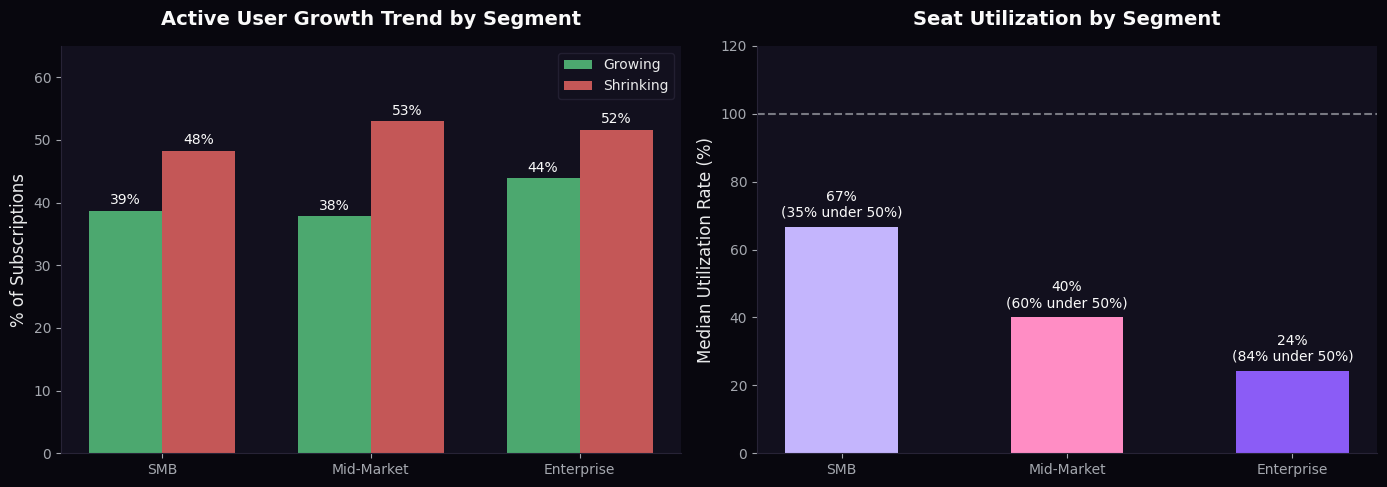

In [10]:
# Visualize seat expansion and utilization by segment
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Reorder segments
segment_order = ['smb', 'mid_market', 'enterprise']
segment_labels = {'smb': 'SMB', 'mid_market': 'Mid-Market', 'enterprise': 'Enterprise'}

# Chart 1: Active User Growth Direction
ax1 = axes[0]
growth_ordered = growth_by_segment.set_index('segment').loc[segment_order].reset_index()
x = np.arange(len(segment_order))
width = 0.35

bars1 = ax1.bar(x - width/2, growth_ordered['pct_growing'], width, 
                label='Growing', color='#4ca86f')  # green
bars2 = ax1.bar(x + width/2, growth_ordered['pct_shrinking'], width, 
                label='Shrinking', color='#c45757')  # red

ax1.set_ylabel('% of Subscriptions')
ax1.set_title('Active User Growth Trend by Segment', fontweight='bold', pad=15)
ax1.set_xticks(x)
ax1.set_xticklabels([segment_labels[s] for s in segment_order])
ax1.legend(loc='upper right')
ax1.set_ylim(0, 65)

for bar in bars1:
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{bar.get_height():.0f}%', ha='center', fontsize=10, color='#FAFAFA')
for bar in bars2:
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{bar.get_height():.0f}%', ha='center', fontsize=10, color='#FAFAFA')

# Chart 2: Seat Utilization Rate
ax2 = axes[1]
util_ordered = util_by_segment.set_index('segment').loc[segment_order].reset_index()
bars3 = ax2.bar([segment_labels[s] for s in segment_order], 
                util_ordered['median_utilization'] * 100, 
                color=CATEGORICAL_PALETTE[:3], width=0.5)
ax2.axhline(y=100, color='#a4a7ae', linestyle='--', alpha=0.7, label='Full Utilization')
ax2.set_ylabel('Median Utilization Rate (%)')
ax2.set_title('Seat Utilization by Segment', fontweight='bold', pad=15)
ax2.set_ylim(0, 120)

for bar, pct_under in zip(bars3, util_ordered['pct_under']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 3, 
             f'{bar.get_height():.0f}%\n({pct_under:.0f}% under 50%)', 
             ha='center', fontsize=10, color='#FAFAFA')

plt.tight_layout()
plt.show()

In [11]:
# Load accounts with status for retention analysis
accounts_query = """
SELECT account_id, status, segment
FROM accounts
"""
accounts = pd.read_sql(accounts_query, engine)

# Calculate average collaboration metrics per account
collab_metrics = activity.groupby('account_id').agg(
    avg_shared_boards=('shared_boards', 'mean'),
    avg_comments=('comments', 'mean'),
    avg_coedit_sessions=('coedit_sessions', 'mean'),
    total_activity_months=('activity_month', 'nunique'),
    avg_active_users=('active_users', 'mean')
).reset_index()

# Merge with account status
retention_analysis = collab_metrics.merge(accounts, on='account_id', how='inner')
retention_analysis['retained'] = (retention_analysis['status'] == 'active').astype(int)

# Create collaboration intensity score (normalized)
retention_analysis['collab_score'] = (
    retention_analysis['avg_shared_boards'] + 
    retention_analysis['avg_comments'] / 5 +  # Scale comments down
    retention_analysis['avg_coedit_sessions'] * 2  # Weight co-editing higher
)

print(f"Accounts analyzed: {len(retention_analysis):,}")
print(f"Retention rate: {retention_analysis['retained'].mean()*100:.1f}%")
print(f"\nRetention by status:")
print(retention_analysis['status'].value_counts())

Accounts analyzed: 2,000
Retention rate: 82.9%

Retention by status:
status
active     1658
churned     342
Name: count, dtype: int64


/var/folders/yj/2fhp0frx3z5ct5ktb9z_43l40000gn/T/ipykernel_90372/3105781663.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  retention_by_q = retention_analysis.groupby(metric)['retained'].agg(['mean', 'count']).reset_index()
/var/folders/yj/2fhp0frx3z5ct5ktb9z_43l40000gn/T/ipykernel_90372/3105781663.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  retention_by_q = retention_analysis.groupby(metric)['retained'].agg(['mean', 'count']).reset_index()
/var/folders/yj/2fhp0frx3z5ct5ktb9z_43l40000gn/T/ipykernel_90372/3105781663.py:18: FutureWarning: The default of observed=False is deprecated and will be ch

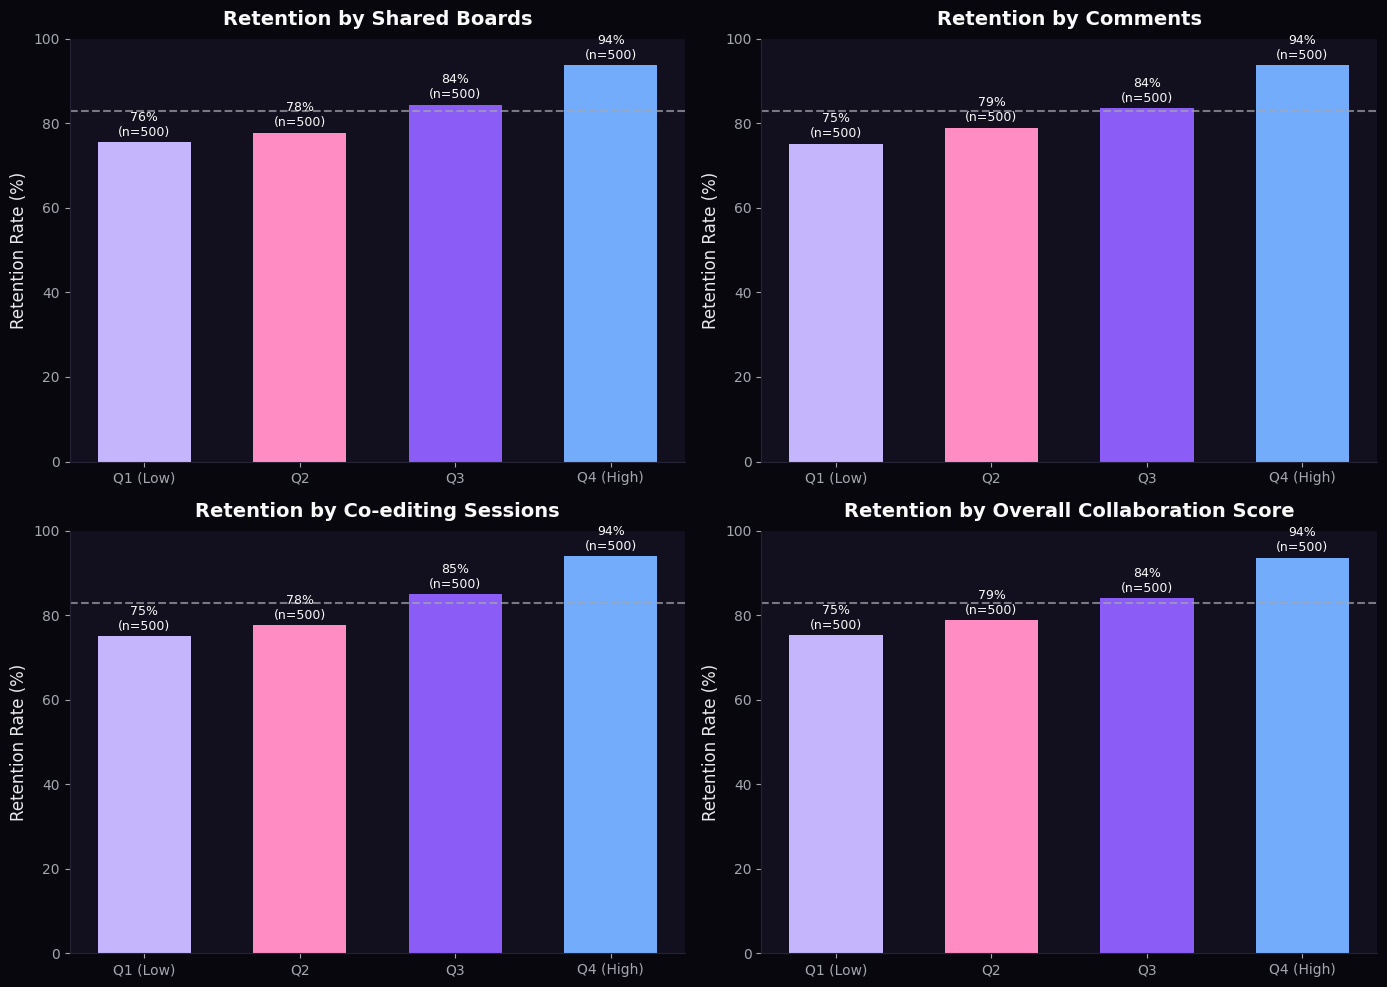


📊 Retention Lift (Q4 High vs Q1 Low):
  Shared Boards: +18.2 pp (76% → 94%)
  Comments: +18.6 pp (75% → 94%)
  Co-editing Sessions: +19.0 pp (75% → 94%)
  Overall Collaboration Score: +18.4 pp (75% → 94%)


In [12]:
# Analyze retention by collaboration quartiles
for metric in ['avg_shared_boards', 'avg_comments', 'avg_coedit_sessions', 'collab_score']:
    retention_analysis[f'{metric}_quartile'] = pd.qcut(
        retention_analysis[metric], q=4, labels=['Q1 (Low)', 'Q2', 'Q3', 'Q4 (High)']
    )

# Retention rate by collaboration quartile
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = [
    ('avg_shared_boards_quartile', 'Shared Boards'),
    ('avg_comments_quartile', 'Comments'),
    ('avg_coedit_sessions_quartile', 'Co-editing Sessions'),
    ('collab_score_quartile', 'Overall Collaboration Score')
]

for ax, (metric, title) in zip(axes.flatten(), metrics):
    retention_by_q = retention_analysis.groupby(metric)['retained'].agg(['mean', 'count']).reset_index()
    retention_by_q['retention_pct'] = retention_by_q['mean'] * 100
    
    bars = ax.bar(retention_by_q[metric], retention_by_q['retention_pct'], 
                  color=CATEGORICAL_PALETTE[:4], width=0.6)
    
    ax.set_ylabel('Retention Rate (%)')
    ax.set_title(f'Retention by {title}', fontweight='bold', pad=10)
    ax.set_ylim(0, 100)
    ax.axhline(y=82.9, color='#a4a7ae', linestyle='--', alpha=0.7, label='Overall avg (83%)')
    
    for bar, (_, row) in zip(bars, retention_by_q.iterrows()):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1.5, 
                f'{row["retention_pct"]:.0f}%\n(n={row["count"]:.0f})', 
                ha='center', fontsize=9, color='#FAFAFA')

plt.tight_layout()
plt.show()

# Calculate lift from Q1 to Q4
print("\n📊 Retention Lift (Q4 High vs Q1 Low):")
for metric, title in metrics:
    q1_ret = retention_analysis[retention_analysis[metric] == 'Q1 (Low)']['retained'].mean()
    q4_ret = retention_analysis[retention_analysis[metric] == 'Q4 (High)']['retained'].mean()
    lift = (q4_ret - q1_ret) * 100
    print(f"  {title}: {lift:+.1f} pp ({q1_ret*100:.0f}% → {q4_ret*100:.0f}%)")

In [13]:
# Load pipeline data with account segment
pipeline_query = """
SELECT p.*, a.segment, a.industry
FROM pipeline p
JOIN accounts a ON p.account_id = a.account_id
"""
pipeline = pd.read_sql(pipeline_query, engine)

# Filter for enterprise segment
enterprise_pipeline = pipeline[pipeline['segment'] == 'enterprise'].copy()
print(f"Total deals: {len(pipeline):,}")
print(f"Enterprise deals: {len(enterprise_pipeline):,}")
print(f"\nProduct bundles: {enterprise_pipeline['product_bundle'].unique()}")
print(f"Deal stages: {enterprise_pipeline['deal_stage'].unique()}")

Total deals: 600
Enterprise deals: 600

Product bundles: ['lucidchart_only' 'spark_scale' 'chart_spark' 'lucidspark_only'
 'full_suite' 'chart_scale' 'lucidscale_only']
Deal stages: ['closed_won' 'closed_lost' 'prospecting' 'proposal' 'negotiation'
 'discovery']


In [14]:
# Analyze pipeline by product bundle
# Define open vs closed stages
closed_stages = ['closed_won', 'closed_lost']
open_stages = ['prospecting', 'discovery', 'proposal', 'negotiation']

enterprise_pipeline['is_closed'] = enterprise_pipeline['deal_stage'].isin(closed_stages)
enterprise_pipeline['is_won'] = enterprise_pipeline['deal_stage'] == 'closed_won'

# Pipeline summary by product bundle
bundle_summary = enterprise_pipeline.groupby('product_bundle').agg(
    total_deals=('deal_id', 'count'),
    total_acv=('acv_usd', 'sum'),
    avg_acv=('acv_usd', 'mean'),
    open_deals=('is_closed', lambda x: (~x).sum()),
    open_acv=('acv_usd', lambda x: x[~enterprise_pipeline.loc[x.index, 'is_closed']].sum()),
    closed_won=('is_won', 'sum'),
    closed_lost=('deal_stage', lambda x: (x == 'closed_lost').sum())
).reset_index()

bundle_summary['win_rate'] = bundle_summary['closed_won'] / (bundle_summary['closed_won'] + bundle_summary['closed_lost']) * 100
bundle_summary['won_acv'] = enterprise_pipeline[enterprise_pipeline['is_won']].groupby('product_bundle')['acv_usd'].sum().reindex(bundle_summary['product_bundle']).values

# Clean up bundle names for display
bundle_labels = {
    'lucidchart_only': 'Lucidchart Only',
    'lucidspark_only': 'Lucidspark Only', 
    'lucidscale_only': 'Lucidscale Only',
    'chart_spark': 'Chart + Spark',
    'chart_scale': 'Chart + Scale',
    'spark_scale': 'Spark + Scale',
    'full_suite': 'Full Suite'
}
bundle_summary['bundle_display'] = bundle_summary['product_bundle'].map(bundle_labels)

# Sort by total ACV
bundle_summary = bundle_summary.sort_values('total_acv', ascending=False)

print("Enterprise Pipeline by Product Bundle:")
print(bundle_summary[['bundle_display', 'total_deals', 'total_acv', 'avg_acv', 'open_deals', 'win_rate']].to_string(index=False))

Enterprise Pipeline by Product Bundle:
 bundle_display  total_deals  total_acv       avg_acv  open_deals  win_rate
     Full Suite          122 16143200.0 132321.311475          61 40.983607
Lucidchart Only          193 10024600.0  51940.932642          92 51.485149
  Chart + Spark           60  9729500.0 162158.333333          25 45.714286
Lucidspark Only          105  5597700.0  53311.428571          50 47.272727
  Chart + Scale           34  5389800.0 158523.529412          20 21.428571
  Spark + Scale           24  3702000.0 154250.000000          14 20.000000
Lucidscale Only           62  2859100.0  46114.516129          38 66.666667


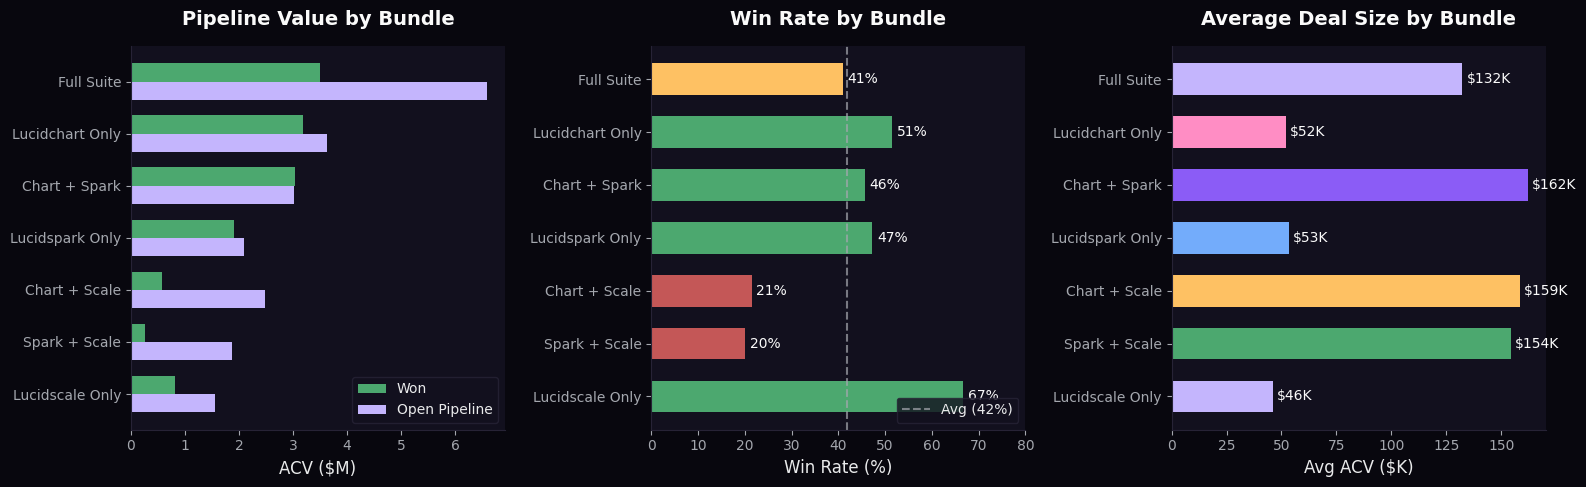


📊 Enterprise Pipeline Summary:
   Open Pipeline: $21.3M across 300 deals
   Won YTD: $13.3M
   Overall Win Rate: 47%


In [15]:
# Visualize enterprise pipeline by product bundle
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Sort for consistent ordering
bundle_order = bundle_summary['bundle_display'].tolist()

# Chart 1: Pipeline Value (Open vs Won)
ax1 = axes[0]
x = np.arange(len(bundle_order))
width = 0.35

won_acv = bundle_summary['won_acv'].fillna(0) / 1e6
open_acv = bundle_summary['open_acv'] / 1e6

bars1 = ax1.barh(x - width/2, won_acv, width, label='Won', color='#4ca86f')
bars2 = ax1.barh(x + width/2, open_acv, width, label='Open Pipeline', color='#c4b5fd')

ax1.set_xlabel('ACV ($M)')
ax1.set_title('Pipeline Value by Bundle', fontweight='bold', pad=15)
ax1.set_yticks(x)
ax1.set_yticklabels(bundle_order)
ax1.legend(loc='lower right')
ax1.invert_yaxis()

# Chart 2: Win Rate
ax2 = axes[1]
colors = ['#4ca86f' if wr >= 45 else '#fec163' if wr >= 30 else '#c45757' 
          for wr in bundle_summary['win_rate']]
bars3 = ax2.barh(bundle_order, bundle_summary['win_rate'], color=colors, height=0.6)
ax2.axvline(x=bundle_summary['win_rate'].mean(), color='#a4a7ae', linestyle='--', 
            alpha=0.7, label=f"Avg ({bundle_summary['win_rate'].mean():.0f}%)")
ax2.set_xlabel('Win Rate (%)')
ax2.set_title('Win Rate by Bundle', fontweight='bold', pad=15)
ax2.set_xlim(0, 80)
ax2.legend(loc='lower right')
ax2.invert_yaxis()

for bar, wr in zip(bars3, bundle_summary['win_rate']):
    ax2.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
             f'{wr:.0f}%', va='center', fontsize=10, color='#FAFAFA')

# Chart 3: Average Deal Size
ax3 = axes[2]
avg_acv = bundle_summary['avg_acv'] / 1000
bars4 = ax3.barh(bundle_order, avg_acv, color=CATEGORICAL_PALETTE[:len(bundle_order)], height=0.6)
ax3.set_xlabel('Avg ACV ($K)')
ax3.set_title('Average Deal Size by Bundle', fontweight='bold', pad=15)
ax3.invert_yaxis()

for bar, acv in zip(bars4, avg_acv):
    ax3.text(bar.get_width() + 2, bar.get_y() + bar.get_height()/2, 
             f'${acv:.0f}K', va='center', fontsize=10, color='#FAFAFA')

plt.tight_layout()
plt.show()

# Summary stats
total_open = bundle_summary['open_acv'].sum()
total_won = bundle_summary['won_acv'].fillna(0).sum()
print(f"\n📊 Enterprise Pipeline Summary:")
print(f"   Open Pipeline: ${total_open/1e6:.1f}M across {bundle_summary['open_deals'].sum()} deals")
print(f"   Won YTD: ${total_won/1e6:.1f}M")
print(f"   Overall Win Rate: {bundle_summary['closed_won'].sum() / (bundle_summary['closed_won'].sum() + bundle_summary['closed_lost'].sum()) * 100:.0f}%")